In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import tensorflow as tf
import pyupbit
import pybithumb
import ccxt
import datetime
%matplotlib inline
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams["figure.figsize"] = (14,10) #그림(figure)의 크기. (가로,세로) 인치 단위
plt.rcParams['lines.linewidth'] = 2 #선의 두께
# plt.rcParams['lines.color'] = 'r' #선의 색깔
plt.rcParams['axes.grid'] = True #차트내 격자선(grid) 표시 여부
# 경고메세지 무시용
pd.set_option('mode.chained_assignment',  None) 

from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from multiprocessing.dummy import Pool
from prophet import Prophet

timeseries = dict()

def get_timeserie(id):
    return timeseries[id]
#     return (timeseries[id], 14, True)

def run_prophet(id, periods=14, include_history=True):
    timeserie = get_timeserie(id)
    model = Prophet(uncertainty_samples=False)
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=periods, include_history=include_history)
    forecast = model.predict(forecast)
#     return np.append(np.array([id]),forecast['yhat'].values.transpose())
    return (id, forecast)

binance = ccxt.binance()
markets = binance.fetch_tickers()

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Parallelism on 16 CPU


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.30s/it]


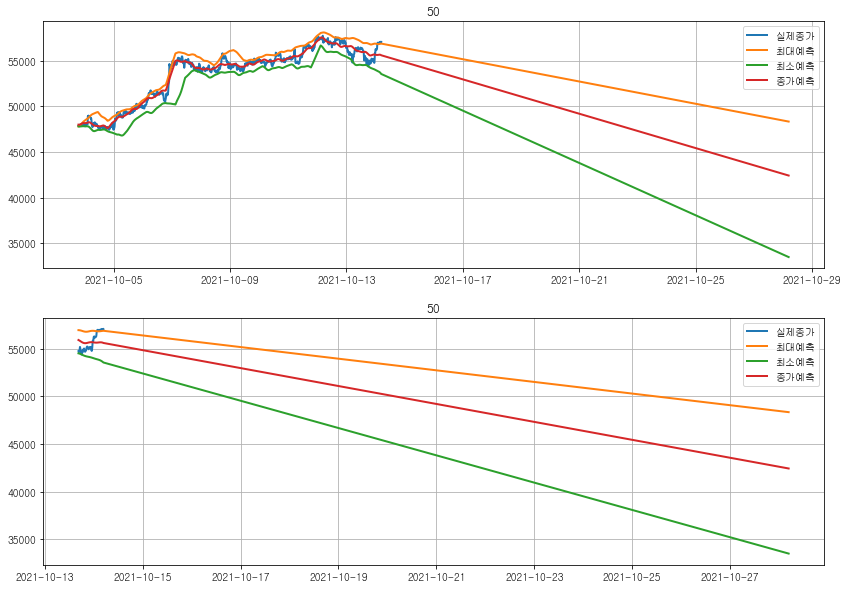

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Parallelism on 16 CPU


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.39s/it]


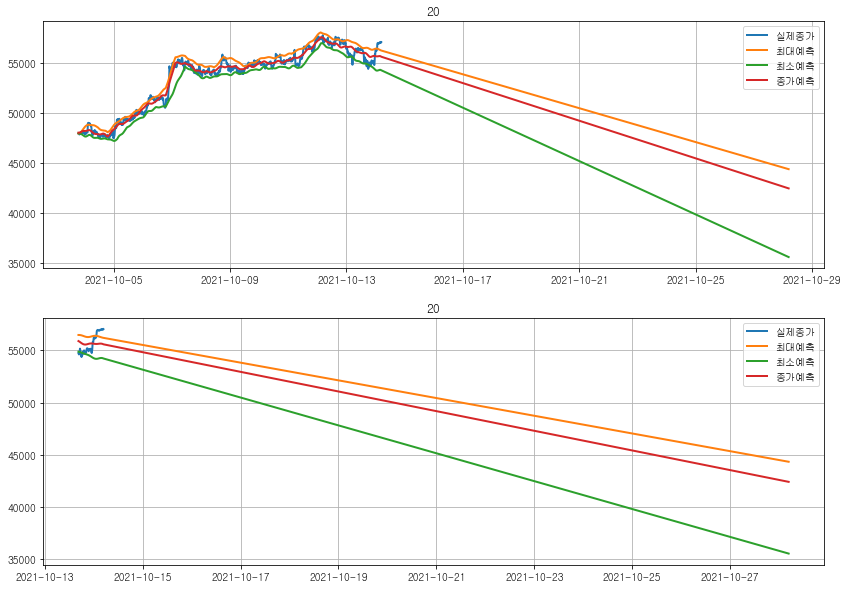

In [2]:
ohlcv = binance.fetch_ohlcv('BTC/USDT', timeframe='15m', limit=14000)
dft = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
for i in dft.index:
    dft['Date'][i] = datetime.datetime.fromtimestamp(dft['Date'][i]/1000)#.strftime('%Y-%m-%d %H:%M:%S')
dft.set_index('Date', inplace=True)
n = 50
dft['ndays_high'] = dft['High'].rolling(window=n, min_periods=1).max()
dft['ndays_low'] = dft['Low'].rolling(window=n, min_periods=1).min()
dfh = pd.DataFrame(dft.sort_index().reset_index(), columns=['Date', 'Close', 'ndays_high', 'ndays_low'])
dfhh = dfh.rename(columns = {'Date':'ds', 'ndays_high':'y'})
dfhl = dfh.rename(columns = {'Date':'ds', 'ndays_low':'y'})
dfhc = dfh.rename(columns = {'Date':'ds', 'Close':'y'})
timeseries = {
    1:dfhh, 2:dfhl, 3:dfhc
}
keys = list(timeseries.keys())
print(f'Parallelism on {cpu_count()} CPU')
with Pool(cpu_count()) as p:
    predictions  = list(tqdm(p.imap(run_prophet, keys), total=len(keys)))

plt.subplot(211)
plt.plot(dfh['Date'], dfh['Close'], label='실제종가')
plt.plot(predictions[0][1]['ds'], predictions[0][1]['yhat'], label='최대예측')
plt.plot(predictions[1][1]['ds'], predictions[1][1]['yhat'], label='최소예측')
plt.plot(predictions[2][1]['ds'], predictions[2][1]['yhat'], label='종가예측')
plt.legend()
plt.title(n)
plt.subplot(212)
plt.plot(dfh['Date'][-50:], dfh['Close'][-50:], label='실제종가')
plt.plot(predictions[0][1]['ds'][-50-14:], predictions[0][1]['yhat'][-50-14:], label='최대예측')
plt.plot(predictions[1][1]['ds'][-50-14:], predictions[1][1]['yhat'][-50-14:], label='최소예측')
plt.plot(predictions[2][1]['ds'][-50-14:], predictions[2][1]['yhat'][-50-14:], label='종가예측')
plt.legend()
plt.title(n)
plt.show()

n = 20
dft['ndays_high'] = dft['High'].rolling(window=n, min_periods=1).max()
dft['ndays_low'] = dft['Low'].rolling(window=n, min_periods=1).min()
dfh = pd.DataFrame(dft.sort_index().reset_index(), columns=['Date', 'Close', 'ndays_high', 'ndays_low'])
dfhh = dfh.rename(columns = {'Date':'ds', 'ndays_high':'y'})
dfhl = dfh.rename(columns = {'Date':'ds', 'ndays_low':'y'})
dfhc = dfh.rename(columns = {'Date':'ds', 'Close':'y'})
timeseries = {
    1:dfhh, 2:dfhl, 3:dfhc
}
keys = list(timeseries.keys())
print(f'Parallelism on {cpu_count()} CPU')
with Pool(cpu_count()) as p:
    predictions  = list(tqdm(p.imap(run_prophet, keys), total=len(keys)))

plt.subplot(211)
plt.plot(dfh['Date'], dfh['Close'], label='실제종가')
plt.plot(predictions[0][1]['ds'], predictions[0][1]['yhat'], label='최대예측')
plt.plot(predictions[1][1]['ds'], predictions[1][1]['yhat'], label='최소예측')
plt.plot(predictions[2][1]['ds'], predictions[2][1]['yhat'], label='종가예측')
plt.legend()
plt.title(n)
plt.subplot(212)
plt.plot(dfh['Date'][-50:], dfh['Close'][-50:], label='실제종가')
plt.plot(predictions[0][1]['ds'][-50-14:], predictions[0][1]['yhat'][-50-14:], label='최대예측')
plt.plot(predictions[1][1]['ds'][-50-14:], predictions[1][1]['yhat'][-50-14:], label='최소예측')
plt.plot(predictions[2][1]['ds'][-50-14:], predictions[2][1]['yhat'][-50-14:], label='종가예측')
plt.legend()
plt.title(n)
plt.show()

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Parallelism on 16 CPU


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.12s/it]


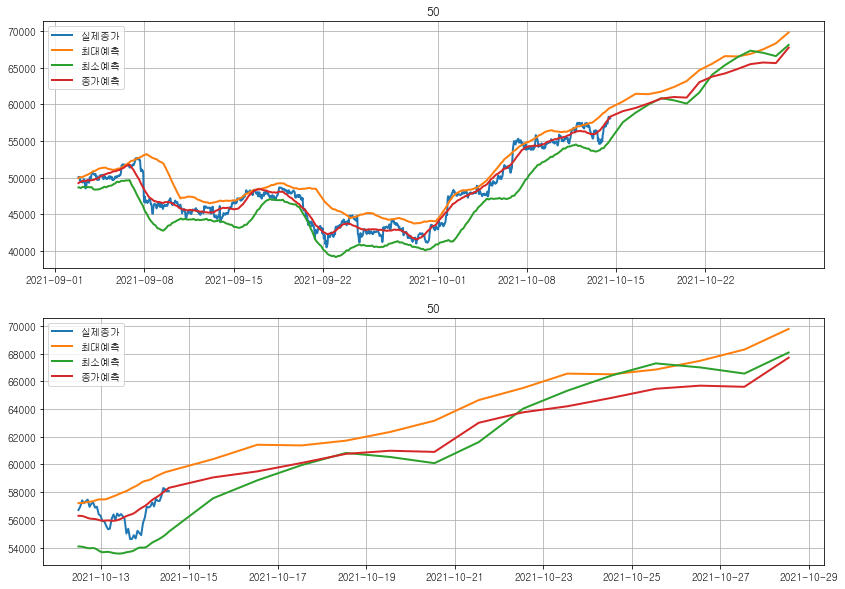

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Parallelism on 16 CPU


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.04s/it]


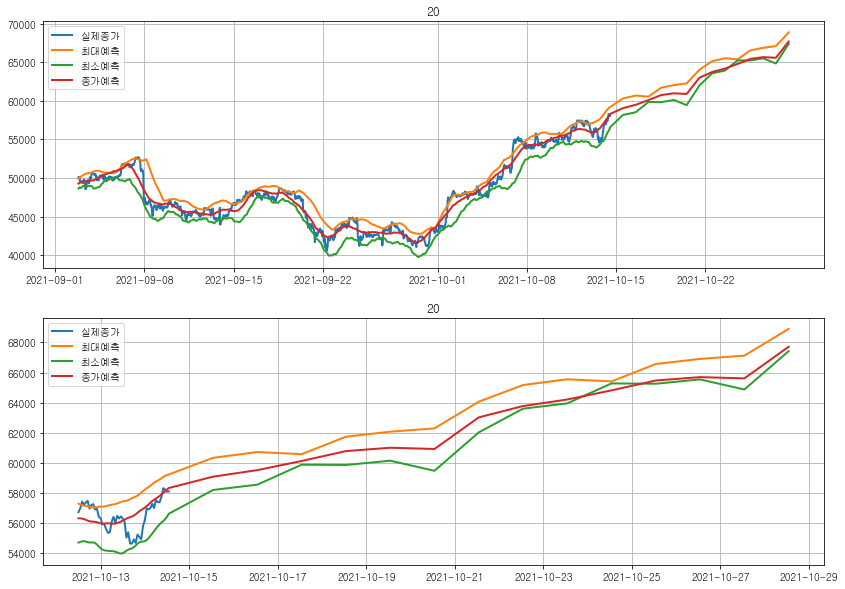

In [7]:
ohlcv = binance.fetch_ohlcv('BTC/USDT', timeframe='1h', limit=14000)
dft = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
for i in dft.index:
    dft['Date'][i] = datetime.datetime.fromtimestamp(dft['Date'][i]/1000)#.strftime('%Y-%m-%d %H:%M:%S')
dft.set_index('Date', inplace=True)
n = 50
dft['ndays_high'] = dft['High'].rolling(window=n, min_periods=1).max()
dft['ndays_low'] = dft['Low'].rolling(window=n, min_periods=1).min()
dfh = pd.DataFrame(dft.sort_index().reset_index(), columns=['Date', 'Close', 'ndays_high', 'ndays_low'])
dfhh = dfh.rename(columns = {'Date':'ds', 'ndays_high':'y'})
dfhl = dfh.rename(columns = {'Date':'ds', 'ndays_low':'y'})
dfhc = dfh.rename(columns = {'Date':'ds', 'Close':'y'})
timeseries = {
    1:dfhh, 2:dfhl, 3:dfhc
}
keys = list(timeseries.keys())
print(f'Parallelism on {cpu_count()} CPU')
with Pool(cpu_count()) as p:
    predictions  = list(tqdm(p.imap(run_prophet, keys), total=len(keys)))

plt.subplot(211)
plt.plot(dfh['Date'], dfh['Close'], label='실제종가')
plt.plot(predictions[0][1]['ds'], predictions[0][1]['yhat'], label='최대예측')
plt.plot(predictions[1][1]['ds'], predictions[1][1]['yhat'], label='최소예측')
plt.plot(predictions[2][1]['ds'], predictions[2][1]['yhat'], label='종가예측')
plt.legend()
plt.title(n)
plt.subplot(212)
plt.plot(dfh['Date'][-50:], dfh['Close'][-50:], label='실제종가')
plt.plot(predictions[0][1]['ds'][-50-14:], predictions[0][1]['yhat'][-50-14:], label='최대예측')
plt.plot(predictions[1][1]['ds'][-50-14:], predictions[1][1]['yhat'][-50-14:], label='최소예측')
plt.plot(predictions[2][1]['ds'][-50-14:], predictions[2][1]['yhat'][-50-14:], label='종가예측')
plt.legend()
plt.title(n)
plt.show()

n = 20
dft['ndays_high'] = dft['High'].rolling(window=n, min_periods=1).max()
dft['ndays_low'] = dft['Low'].rolling(window=n, min_periods=1).min()
dfh = pd.DataFrame(dft.sort_index().reset_index(), columns=['Date', 'Close', 'ndays_high', 'ndays_low'])
dfhh = dfh.rename(columns = {'Date':'ds', 'ndays_high':'y'})
dfhl = dfh.rename(columns = {'Date':'ds', 'ndays_low':'y'})
dfhc = dfh.rename(columns = {'Date':'ds', 'Close':'y'})
timeseries = {
    1:dfhh, 2:dfhl, 3:dfhc
}
keys = list(timeseries.keys())
print(f'Parallelism on {cpu_count()} CPU')
with Pool(cpu_count()) as p:
    predictions  = list(tqdm(p.imap(run_prophet, keys), total=len(keys)))

plt.subplot(211)
plt.plot(dfh['Date'], dfh['Close'], label='실제종가')
plt.plot(predictions[0][1]['ds'], predictions[0][1]['yhat'], label='최대예측')
plt.plot(predictions[1][1]['ds'], predictions[1][1]['yhat'], label='최소예측')
plt.plot(predictions[2][1]['ds'], predictions[2][1]['yhat'], label='종가예측')
plt.legend()
plt.title(n)
plt.subplot(212)
plt.plot(dfh['Date'][-50:], dfh['Close'][-50:], label='실제종가')
plt.plot(predictions[0][1]['ds'][-50-14:], predictions[0][1]['yhat'][-50-14:], label='최대예측')
plt.plot(predictions[1][1]['ds'][-50-14:], predictions[1][1]['yhat'][-50-14:], label='최소예측')
plt.plot(predictions[2][1]['ds'][-50-14:], predictions[2][1]['yhat'][-50-14:], label='종가예측')
plt.legend()
plt.title(n)
plt.show()

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Parallelism on 16 CPU


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


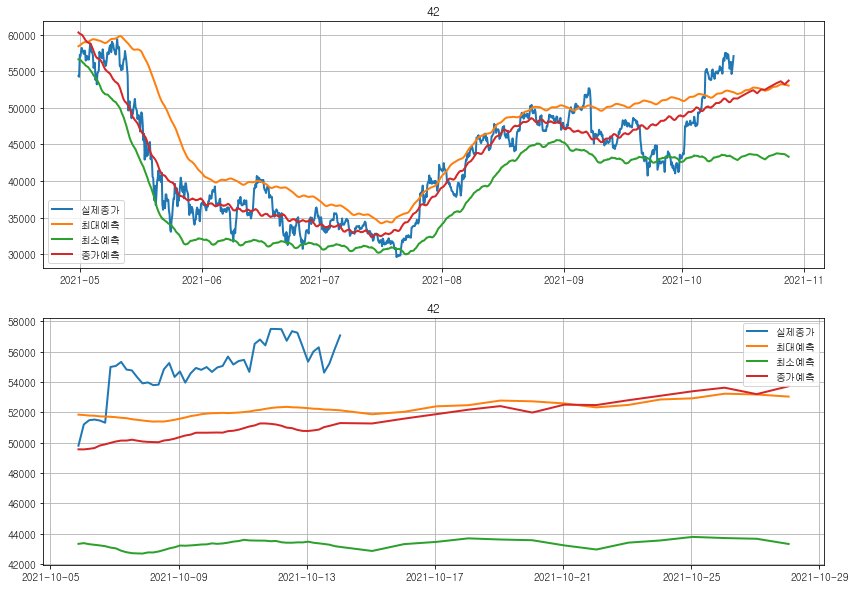

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Parallelism on 16 CPU


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.41s/it]


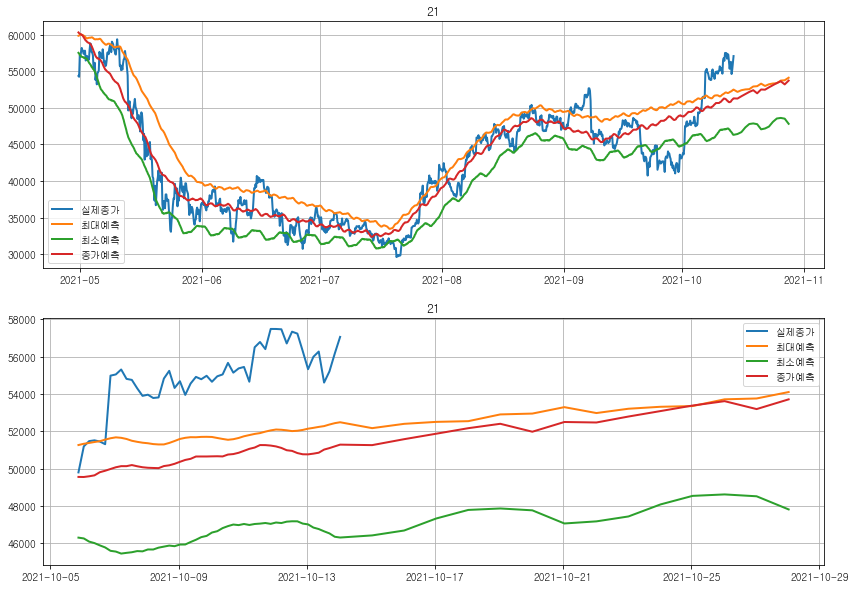

In [4]:
ohlcv = binance.fetch_ohlcv('BTC/USDT', timeframe='4h', limit=14000)
dft = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
for i in dft.index:
    dft['Date'][i] = datetime.datetime.fromtimestamp(dft['Date'][i]/1000)#.strftime('%Y-%m-%d %H:%M:%S')
dft.set_index('Date', inplace=True)
n = 42
dft['ndays_high'] = dft['High'].rolling(window=n, min_periods=1).max()
dft['ndays_low'] = dft['Low'].rolling(window=n, min_periods=1).min()
dfh = pd.DataFrame(dft.sort_index().reset_index(), columns=['Date', 'Close', 'ndays_high', 'ndays_low'])
dfhh = dfh.rename(columns = {'Date':'ds', 'ndays_high':'y'})
dfhl = dfh.rename(columns = {'Date':'ds', 'ndays_low':'y'})
dfhc = dfh.rename(columns = {'Date':'ds', 'Close':'y'})
timeseries = {
    1:dfhh, 2:dfhl, 3:dfhc
}
keys = list(timeseries.keys())
print(f'Parallelism on {cpu_count()} CPU')
with Pool(cpu_count()) as p:
    predictions  = list(tqdm(p.imap(run_prophet, keys), total=len(keys)))

plt.subplot(211)
plt.plot(dfh['Date'], dfh['Close'], label='실제종가')
plt.plot(predictions[0][1]['ds'], predictions[0][1]['yhat'], label='최대예측')
plt.plot(predictions[1][1]['ds'], predictions[1][1]['yhat'], label='최소예측')
plt.plot(predictions[2][1]['ds'], predictions[2][1]['yhat'], label='종가예측')
plt.legend()
plt.title(n)
plt.subplot(212)
plt.plot(dfh['Date'][-50:], dfh['Close'][-50:], label='실제종가')
plt.plot(predictions[0][1]['ds'][-50-14:], predictions[0][1]['yhat'][-50-14:], label='최대예측')
plt.plot(predictions[1][1]['ds'][-50-14:], predictions[1][1]['yhat'][-50-14:], label='최소예측')
plt.plot(predictions[2][1]['ds'][-50-14:], predictions[2][1]['yhat'][-50-14:], label='종가예측')
plt.legend()
plt.title(n)
plt.show()

n = 21
dft['ndays_high'] = dft['High'].rolling(window=n, min_periods=1).max()
dft['ndays_low'] = dft['Low'].rolling(window=n, min_periods=1).min()
dfh = pd.DataFrame(dft.sort_index().reset_index(), columns=['Date', 'Close', 'ndays_high', 'ndays_low'])
dfhh = dfh.rename(columns = {'Date':'ds', 'ndays_high':'y'})
dfhl = dfh.rename(columns = {'Date':'ds', 'ndays_low':'y'})
dfhc = dfh.rename(columns = {'Date':'ds', 'Close':'y'})
timeseries = {
    1:dfhh, 2:dfhl, 3:dfhc
}
keys = list(timeseries.keys())
print(f'Parallelism on {cpu_count()} CPU')
with Pool(cpu_count()) as p:
    predictions  = list(tqdm(p.imap(run_prophet, keys), total=len(keys)))

plt.subplot(211)
plt.plot(dfh['Date'], dfh['Close'], label='실제종가')
plt.plot(predictions[0][1]['ds'], predictions[0][1]['yhat'], label='최대예측')
plt.plot(predictions[1][1]['ds'], predictions[1][1]['yhat'], label='최소예측')
plt.plot(predictions[2][1]['ds'], predictions[2][1]['yhat'], label='종가예측')
plt.legend()
plt.title(n)
plt.subplot(212)
plt.plot(dfh['Date'][-50:], dfh['Close'][-50:], label='실제종가')
plt.plot(predictions[0][1]['ds'][-50-14:], predictions[0][1]['yhat'][-50-14:], label='최대예측')
plt.plot(predictions[1][1]['ds'][-50-14:], predictions[1][1]['yhat'][-50-14:], label='최소예측')
plt.plot(predictions[2][1]['ds'][-50-14:], predictions[2][1]['yhat'][-50-14:], label='종가예측')
plt.legend()
plt.title(n)
plt.show()

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Parallelism on 16 CPU


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.52s/it]


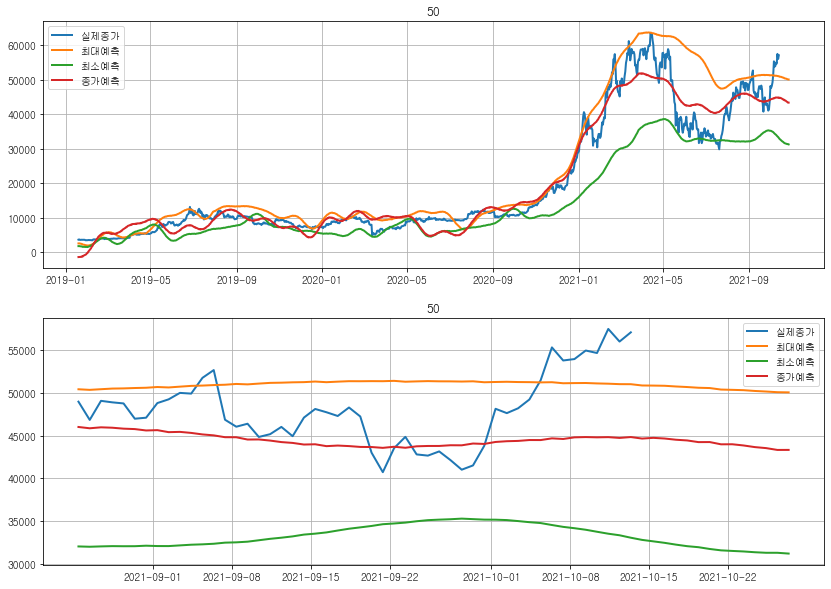

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Parallelism on 16 CPU


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


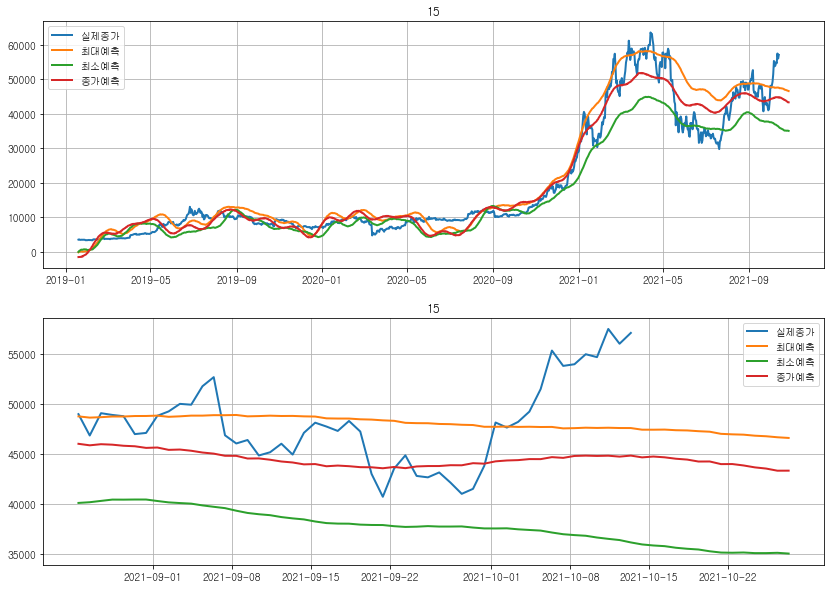

In [5]:
ohlcv = binance.fetch_ohlcv('BTC/USDT', timeframe='1d', limit=14000)
dft = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
for i in dft.index:
    dft['Date'][i] = datetime.datetime.fromtimestamp(dft['Date'][i]/1000)#.strftime('%Y-%m-%d %H:%M:%S')
dft.set_index('Date', inplace=True)
n = 50
dft['ndays_high'] = dft['High'].rolling(window=n, min_periods=1).max()
dft['ndays_low'] = dft['Low'].rolling(window=n, min_periods=1).min()
dfh = pd.DataFrame(dft.sort_index().reset_index(), columns=['Date', 'Close', 'ndays_high', 'ndays_low'])
dfhh = dfh.rename(columns = {'Date':'ds', 'ndays_high':'y'})
dfhl = dfh.rename(columns = {'Date':'ds', 'ndays_low':'y'})
dfhc = dfh.rename(columns = {'Date':'ds', 'Close':'y'})
timeseries = {
    1:dfhh, 2:dfhl, 3:dfhc
}
keys = list(timeseries.keys())
print(f'Parallelism on {cpu_count()} CPU')
with Pool(cpu_count()) as p:
    predictions  = list(tqdm(p.imap(run_prophet, keys), total=len(keys)))

plt.subplot(211)
plt.plot(dfh['Date'], dfh['Close'], label='실제종가')
plt.plot(predictions[0][1]['ds'], predictions[0][1]['yhat'], label='최대예측')
plt.plot(predictions[1][1]['ds'], predictions[1][1]['yhat'], label='최소예측')
plt.plot(predictions[2][1]['ds'], predictions[2][1]['yhat'], label='종가예측')
plt.legend()
plt.title(n)
plt.subplot(212)
plt.plot(dfh['Date'][-50:], dfh['Close'][-50:], label='실제종가')
plt.plot(predictions[0][1]['ds'][-50-14:], predictions[0][1]['yhat'][-50-14:], label='최대예측')
plt.plot(predictions[1][1]['ds'][-50-14:], predictions[1][1]['yhat'][-50-14:], label='최소예측')
plt.plot(predictions[2][1]['ds'][-50-14:], predictions[2][1]['yhat'][-50-14:], label='종가예측')
plt.legend()
plt.title(n)
plt.show()

n = 15
dft['ndays_high'] = dft['High'].rolling(window=n, min_periods=1).max()
dft['ndays_low'] = dft['Low'].rolling(window=n, min_periods=1).min()
dfh = pd.DataFrame(dft.sort_index().reset_index(), columns=['Date', 'Close', 'ndays_high', 'ndays_low'])
dfhh = dfh.rename(columns = {'Date':'ds', 'ndays_high':'y'})
dfhl = dfh.rename(columns = {'Date':'ds', 'ndays_low':'y'})
dfhc = dfh.rename(columns = {'Date':'ds', 'Close':'y'})
timeseries = {
    1:dfhh, 2:dfhl, 3:dfhc
}
keys = list(timeseries.keys())
print(f'Parallelism on {cpu_count()} CPU')
with Pool(cpu_count()) as p:
    predictions  = list(tqdm(p.imap(run_prophet, keys), total=len(keys)))

plt.subplot(211)
plt.plot(dfh['Date'], dfh['Close'], label='실제종가')
plt.plot(predictions[0][1]['ds'], predictions[0][1]['yhat'], label='최대예측')
plt.plot(predictions[1][1]['ds'], predictions[1][1]['yhat'], label='최소예측')
plt.plot(predictions[2][1]['ds'], predictions[2][1]['yhat'], label='종가예측')
plt.legend()
plt.title(n)
plt.subplot(212)
plt.plot(dfh['Date'][-50:], dfh['Close'][-50:], label='실제종가')
plt.plot(predictions[0][1]['ds'][-50-14:], predictions[0][1]['yhat'][-50-14:], label='최대예측')
plt.plot(predictions[1][1]['ds'][-50-14:], predictions[1][1]['yhat'][-50-14:], label='최소예측')
plt.plot(predictions[2][1]['ds'][-50-14:], predictions[2][1]['yhat'][-50-14:], label='종가예측')
plt.legend()
plt.title(n)
plt.show()